In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
])
train = torchvision.datasets.MNIST(root='./data', train=True, download=True,  transform=transform)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True,  transform=transform)

In [ ]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               PILToTensor()
           )

In [ ]:
ds = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
ds_test = torch.utils.data.DataLoader(test, batch_size=64)

In [ ]:
from torch import nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1000),
            nn.ReLU(),
            nn.Linear(1000, 28*28),
            nn.Sigmoid()
        )

    def forward(self, flat):
        return self.model(flat)

class AutoencoderBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 28*28),
            nn.Sigmoid()
        )

    def forward(self, flat):
        return self.model(flat)

# model = Autoencoder()
model = AutoencoderBig()

In [ ]:
@torch.no_grad()
def valid_loss(model, ds_test, loss_fn, device="cuda"):
    summed_loss = 0
    iters = 0
    for batch in ds_test:
        image_tensor = batch[0]
        B, C, H, W = image_tensor.shape
        inputs = image_tensor.view(B, -1)
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)
        inputs /= 255.0

        # 1. forward pass
        outputs = model(inputs)

        # 2. update weights
        loss = loss_fn(outputs, inputs)
        summed_loss += loss.detach().cpu().item()
        iters +=1
    return summed_loss / iters


def _train(model, ds, device="cpu", iterations=None, epochs=1000):
    device = "cuda"
    loss_fn = nn.MSELoss()
    optim = torch.optim.AdamW(model.parameters())
    model.to(device)
    model.train()
    losses = []
    iteration = 0

    for epoch in range(epochs):
        for i, batch in enumerate(ds):
            if iterations is not None and iteration > iterations:
                break

            # 0. process data
            image_tensor = batch[0]
            B, C, H, W = image_tensor.shape
            inputs = image_tensor.view(B, -1) # flatten, but not batches
            inputs = inputs.to(device)
            inputs = inputs.to(torch.float32)
            inputs /= 255.0

            # 1. forward pass
            outputs = model(inputs)

            # 2. update weights
            loss = loss_fn(outputs, inputs)
            optim.zero_grad()
            loss.backward()
            optim.step()

            # 3. log out the losses
            losses.append((iteration, loss.detach().cpu().item()))
            iteration +=1
        valid = valid_loss(model, ds_test, loss_fn, device)
        print(epoch, "train", losses[-1][1], "validation", valid)

    return losses

In [ ]:
def tensor_to_image(image):
    image *= 255
    image = image.to(torch.uint8)
    return Image.fromarray(image.detach().cpu().numpy()).resize((256, 256))

def check(image_tensor, device="cuda"):
    C, H, W = image_tensor.shape
    B = 1
    inputs = image_tensor.view(B, -1) # flatten, but not batches
    inputs = inputs.to(device)
    inputs = inputs.to(torch.float32)
    inputs /= 255.0

    outputs = model(inputs)
    return tensor_to_image(outputs.view(H, W))

In [ ]:
losses = _train(model, ds, device="cuda", epochs=10)

0 train 0.025070317089557648 validation 0.026544288583811682
1 train 0.022228144109249115 validation 0.020967636678581404
2 train 0.019972657784819603 validation 0.01787209737998475
3 train 0.016131289303302765 validation 0.0155518268751111
4 train 0.012622419744729996 validation 0.013525550615540735
5 train 0.011766315437853336 validation 0.012529216166941604
6 train 0.01121400948613882 validation 0.011562040562083008
7 train 0.010252684354782104 validation 0.01129013715181381
8 train 0.010867577977478504 validation 0.010964207312649792
9 train 0.010179199278354645 validation 0.010639419678337635


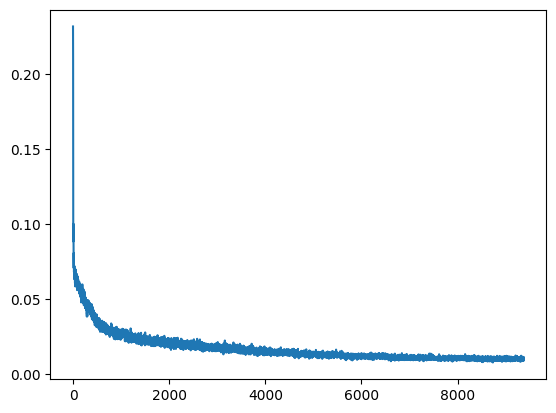

In [ ]:
plt.plot([i[0]for i in losses], [i[1]for i in losses])

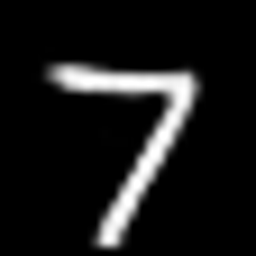

In [ ]:
first = test[0][0]
check(first)

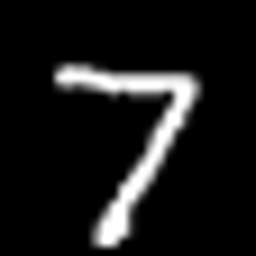

In [ ]:
tensor_to_image(first.squeeze(0))

In [ ]:
torch.save(model.state_dict(), "ae-big.pth")

In [ ]:
%shell ls -hla

total 42M
drwxr-xr-x 1 root root 4.0K Aug 22 22:18 .
drwxr-xr-x 1 root root 4.0K Aug 22 20:49 ..
-rw-r--r-- 1 root root 8.2M Aug 22 22:06 ae-1.pth
-rw-r--r-- 1 root root  34M Aug 22 22:18 ae-big.pth
drwxr-xr-x 4 root root 4.0K Aug 21 13:33 .config
drwxr-xr-x 3 root root 4.0K Aug 22 20:50 data
drwxr-xr-x 1 root root 4.0K Aug 21 13:34 sample_data
